# AMR Allele List

I'd like to identify a list of exonic alleles that may be interesting to genotype
in the AMR population. This list will include both missense and loss-of-function variants.

In [1]:
import cPickle
import os
import subprocess

import matplotlib as mpl

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
import scipy.stats as stats
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Helvetica'] + plt.rcParams['font.sans-serif']

from IPython.display import display, HTML

%matplotlib inline
%load_ext rpy2.ipython

outdir = '../output/amr_allele_list'
if not os.path.exists(outdir):
    os.makedirs(outdir)
private_outdir = '../private_output/amr_allele_list'
if not os.path.exists(private_outdir):
    os.makedirs(private_outdir)

In [2]:
%%R

source("../scripts/PIEMM.r")

In [3]:
# Bring piemm function into python.
piemm_fnc = robjects.r['piemm']

def piemm(betas, ses, priorvar0=0.3**2, paramfix=True, var1fix=1, var2fix=1):
    """Wrapper around R piemm function."""
    res = piemm_fnc(betas, ses, paramfix=paramfix, priorvar0=priorvar0, var1fix=var1fix, var2fix=var2fix)
    mu = pd.DataFrame(pandas2ri.ri2py(res[0]))
    pi = pd.DataFrame(pandas2ri.ri2py(res[1]))
    sigma = pd.DataFrame(pandas2ri.ri2py(res[2]))
    gamma = pd.DataFrame(pandas2ri.ri2py(res[3]))
    meansd = pd.Series(pandas2ri.ri2py(res[4]))
    meanpi = pd.Series(pandas2ri.ri2py(res[5]))
    meanmu = pd.Series(pandas2ri.ri2py(res[6]))
    l95sd = pd.Series(pandas2ri.ri2py(res[7]))
    l95pi = pd.Series(pandas2ri.ri2py(res[8]))
    l95mu = pd.Series(pandas2ri.ri2py(res[9]))
    u95sd = pd.Series(pandas2ri.ri2py(res[10]))
    u95pi = pd.Series(pandas2ri.ri2py(res[11]))
    u95mu = pd.Series(pandas2ri.ri2py(res[12]))

    ires = pd.Panel({'mu':mu, 'sigma': sigma, 'pi':pi})
    ores = pd.DataFrame({'meanmu':meanmu, 'meansd':meansd, 'meanpi':meanpi, 
                         'l95mu':l95mu, 'l95sd':l95sd, 'l95pi':l95pi,
                         'u95mu':u95mu, 'u95sd':u95sd, 'u95pi':u95pi})
    return ires, ores, gamma

In [4]:
def calc_summary_stats(df, popb, popa='NFE'):    
    lofa = df['AC_{}'.format(popa)]
    not_lofa = df['AN_{}'.format(popa)] - lofa
    lofb = df['AC_{}'.format(popb)]
    not_lofb = df['AN_{}'.format(popb)] - lofb
    
    beta = np.log(((0.5 + not_lofa) * (0.5 + lofb)) / ((0.5 + lofa) * (0.5 + not_lofb)))
    stderr2 = 1 / (0.5 + not_lofa) + 1 / (0.5 + not_lofb) + 1 / (0.5 + lofa) + 1 / (0.5 + lofb)
    
    ss = pd.DataFrame({'beta':beta, 'se2':stderr2})
    
    return ss

In [5]:
fn = '/srv/gsfs0/projects/rivas/data/gencode.v19_20170302/parsing/gencode.v19.annotation.table.tsv'
gtable = pd.read_table(fn, index_col=0)
gtable['gencode_id'] = gtable.index
gtable.index = [x.split('.')[0] for x in gtable.index]

In [6]:
# Make file with missense and LoF alleles.
fn = os.path.join(outdir, 'missense_lof.tsv')
if not os.path.exists(fn):
    table = '/srv/gsfs0/projects/rivas/data/gnomad_170228_20170228/parsing/gnomad.exomes.r2.0.1.sites.tsv'
    c = 'awk \'{{if (($22 == "missense_variant") || ($29 != "NA"))  print}}\' {} > {}'.format(table, fn)
    subprocess.check_call(c, shell=True)
vrs = pd.read_table(fn,
                    dtype={'CHROM':str, 'POS':int, 'REF':str, 'ALT':str, 'AC_AFR':int, 'AC_AMR':int, 
                           'AC_ASJ':int, 'AC_EAS':int, 'AC_FIN':int, 'AC_NFE':int, 'AC_OTH':int, 
                           'AC_SAS':int, 'AN_AFR':int, 'AN_AMR':int, 'AN_ASJ':int, 'AN_EAS':int, 
                           'AN_FIN':int, 'AN_NFE':int, 'AN_OTH':int, 'AN_SAS':int, 'Allele':str,
                           'Consequence':str, 'IMPACT':str, 'Gene':str, 'BIOTYPE':str, 'SIFT':str, 
                           'PolyPhen':str, 'CLIN_SIG':str, 'LoF':str, 'LoF_filter':str, 
                           'LoF_flags':str, 'LoF_info':str})

pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]

In [7]:
# Maximum number of chromosomes genotyped per population.
pop_max = vrs[['AN_{}'.format(x) for x in pops]].max()
pop_max.index = [x.split('_')[1] for x in pop_max.index]

In [8]:
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]
    
for pop in pops:
    vrs['GP_{}'.format(pop)] = vrs['AN_{}'.format(pop)].astype(float) / pop_max[pop]

## Allele Enrichment 

For this purpose, I am going to include both LoF and missense variants. I will filter the LoF
variants as I describe below.

### Model

I'm going to calculate effect sizes and standard errors using the methods from http://biorxiv.org/lookup/doi/10.1101/077180. In particular, we can calculate
a bias-corrected log odds ratio and squared standard error as

$$\hat\beta_i = \log(\textrm{OR}_i) = \log\left(\frac{(0.5 + \textrm{LoF}_{a})(0.5 + \textrm{notLoF}_{b})}
{(0.5 + \textrm{notLoF}_{a})(0.5 + \textrm{LoF}_{b})}\right)$$

$$\hat{\textrm{SE}_i}^2 = \frac{1}{0.5 + \textrm{LoF}_{a}} + \frac{1}{0.5 + \textrm{LoF}_{b}}
+ \frac{1}{0.5 + \textrm{notLoF}_{a}} + \frac{1}{0.5 + \textrm{notLoF}_{b}}
$$

for a gene $i$ and two population groups $a$ and $b$. I will compare the AMR to the NFE.

For the LoF counts, I will sum the number of LoF alleles observed for each gene. So if a gene has
one variant site that is LoF but that allele was observed 10 times, that gene will have a count of 10.
Similarly, a gene with 10 LoF sites that are each observed once would also have a count of 10. We are 
assuming that a single person doesn't harbor two LoF variants which should be reasonable if they have
a low frequency.

### LoF variant filtering

I will filter out LoF variants that 

* weren't genotyped in at least 80% of the subjects for all populations
* were assigned to more than one gene
* have an allele frequency greater than 5% in any population
* are low confidence

In [9]:
for pop in pops:
    print('{:.1f}% of variants genotyped at >80% for {}.'.format(
            (vrs['GP_{}'.format(pop)] > 0.80).sum() / float(vrs.shape[0]) * 100, 
            pop))

88.4% of variants genotyped at >80% for AFR.
88.2% of variants genotyped at >80% for AMR.
93.2% of variants genotyped at >80% for ASJ.
88.7% of variants genotyped at >80% for EAS.
87.4% of variants genotyped at >80% for FIN.
88.2% of variants genotyped at >80% for NFE.
88.4% of variants genotyped at >80% for OTH.
88.3% of variants genotyped at >80% for SAS.


In [10]:
# Remove sites that weren't called for at least 80% of haplotypes in all populations.
cols = [x for x in vrs.columns if 'GP_' in x]
m = vrs[cols].min(axis=1)
vrs_f = vrs[m > 0.8]
# Remove sites that are assigned to more than one gene.
vrs_f = vrs_f[vrs_f.Gene.apply(lambda x: ',' not in x)]
# # Remove sites that have an allele frequency greater than 5% in any population.
# vrs_f = vrs_f[vrs_f[[x for x in vrs_f.columns if 'AF_' in x]].max(axis=1) < 0.05]
# # Keep only high confidence sites.
# vrs_f = vrs_f[vrs_f.LoF == 'HC']

In [11]:
17210 * 2 * 2 / 1000.

68.84

In [23]:
missense_variants = vrs_f[(vrs_f.LoF.isnull()) & (vrs_f['AF_AMR'] > 2. / 1000)].index
lof_variants = vrs_f[(vrs_f.LoF.isnull() == False) & (vrs_f['AF_AMR'] > 2. / 10000)].index

In [24]:
summary_stats = {}
tpops = ['AMR']
for pop in tpops:
    summary_stats[pop] = beta, stderr2 = calc_summary_stats(vrs_f, pop)
    
for pop in tpops:
    summary_stats[pop].to_csv(os.path.join(outdir, '{}_ss.tsv'.format(pop)), sep='\t')

### Run model

In [169]:
lof_res = {}
for params in [(0.1**2, 0.05**2, 0.05**2), (0.1**2, 0.5**2, 0.5**2), (0.5**2, 0.5**2, 0.5**2),
               (0.1**2, 0.25**2, 0.25**2)]:
    fn = os.path.join(outdir, 'piemm_lof_{x[0]}_{x[1]}_{x[2]}.pickle'.format(x=params))
    if os.path.exists(fn):
        lof_res[params] = cPickle.load(open(fn))
    else:
        pop = 'AMR'
        betas = summary_stats[pop]['beta'][lof_variants]
        ses = np.sqrt(summary_stats[pop]['se2'][lof_variants])
        ires, ores, gamma = piemm(betas, ses, priorvar0=params[0], var1fix=params[1], var2fix=params[2])
        gamma.index = betas.index
        gamma = gamma / gamma.sum(axis=1).iloc[0]
        lof_res[params] = [ires, ores, gamma]
        with open(fn, 'w') as f:
            cPickle.dump(lof_res[params], f)
            
missense_res = {}
for params in [(0.1**2, 0.05**2, 0.05**2), (0.1**2, 0.5**2, 0.5**2), (0.5**2, 0.5**2, 0.5**2), 
               (0.1**2, 0.25**2, 0.25**2)]:
    fn = os.path.join(outdir, 'piemm_missense_{x[0]}_{x[1]}_{x[2]}.pickle'.format(x=params))
    if os.path.exists(fn):
        missense_res[params] = cPickle.load(open(fn))
    else:
        pop = 'AMR'
        betas = summary_stats[pop]['beta'][missense_variants]
        ses = np.sqrt(summary_stats[pop]['se2'][missense_variants])
        ires, ores, gamma = piemm(betas, ses, priorvar0=params[0], var1fix=params[1], var2fix=params[2])
        gamma.index = betas.index
        gamma = gamma / gamma.sum(axis=1).iloc[0]
        missense_res[params] = [ires, ores, gamma]
        with open(fn, 'w') as f:
            cPickle.dump(missense_res[params], f)

In [175]:
def plot_norms(mus, sigmas, ax=None, percent=0.99):
    mus = list(mus)
    sigmas = list(sigmas)
    # Define max and min.
    xmax = max([stats.norm.ppf(percent, mus[i], sigmas[i]) for i in range(len(mus))] + 
               [abs(stats.norm.ppf(1 - percent, mus[i], sigmas[i])) for i in range(len(mus))])
    xmin = -xmax
    x = np.linspace(xmin, xmax, 100)
    if ax is None:
        fig, ax = plt.subplots(1)
    for i in range(len(mus)):
        ax.plot(x, stats.norm.pdf(x, mus[i], sigmas[i]), label=i)
    ax.legend()
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group distributions')

def visualize_piemm_res(pop, piemm_res, summary_stats):
    display(HTML('<h4>Results for {}</h4>'.format(pop)))
    ires, ores, gamma = piemm_res
    sum_stats = summary_stats
    fig, axs = plt.subplots(6, 2, figsize=(10, 15))
    display(ores)
    
    plot_num = 0
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meanmu)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95mu'], ores.ix[i, 'u95mu'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\mu$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meansd)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95sd'], ores.ix[i, 'u95sd'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\sigma$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meanpi)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95pi'], ores.ix[i, 'u95pi'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\pi$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['mu'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\mu$')
    ax.set_title('$\mu$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['sigma'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\sigma$')
    ax.set_title('$\sigma$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['pi'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\pi$')
    ax.set_title('$\pi$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    plot_norms(ores.meanmu, ores.meansd, ax=ax)
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    sum_stats['group'] = gamma.idxmax(axis=1).values
    xmax = np.ceil(sum_stats.beta.abs().max())
    xmin = -xmax
    step = (xmax - xmin) / 100.
    toplot = []
    for i in [2, 0, 1]:
        toplot.append(sum_stats.ix[sum_stats.group == i, 'beta'].values)
    ax.hist(toplot, stacked=True, bins=np.arange(xmin, xmax + step, step), label=[2, 0, 1], 
            color=[sns.color_palette()[2], sns.color_palette()[0], sns.color_palette()[1]])
    ax.set_xlabel('Beta')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of betas stratified by group membership')
    ax.legend()
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    bins = np.linspace(sum_stats.beta.min(), sum_stats.beta.max(), 100)
    sum_stats = sum_stats.join(gamma)
    sum_stats['bin'] = pd.cut(sum_stats.beta, bins)
    psums = sum_stats.groupby('bin')[[0, 1, 2]].sum().replace(np.nan, 0)

    ax.bar(bins[0:psums.shape[0]], psums[2], width=bins[1] - bins[0], label=2)
    ax.bar(bins[0:psums.shape[0]], psums[0], bottom=psums[2], width=bins[1] - bins[0], label=2)
    ax.bar(bins[0:psums.shape[0]], psums[1], bottom=(psums[2] + psums[0]), width=bins[1] - bins[0], label=2)
    ax.set_xlabel('Beta')
    ax.set_ylabel('Sum of posterior probability')
    ax.set_title('Posterior probability vs. beta')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 2
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
#     xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
#     xmax = stats.norm.ppf(0.99, mu, sigma)
    if len(toplot[tpi]) == 0:
        xmin = 0
        xmax = 1
    else:
        xmin = min(toplot[tpi])
        xmax = max(toplot[tpi])
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 0
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
#     xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
#     xmax = stats.norm.ppf(0.99, mu, sigma)
    if len(toplot[tpi]) == 0:
        xmin = 0
        xmax = 1
    else:
        xmin = min(toplot[tpi])
        xmax = max(toplot[tpi])
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 1
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
#     xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
#     xmax = stats.norm.ppf(0.99, mu, sigma)
    if len(toplot[tpi]) == 0:
        xmin = 0
        xmax = 1
    else:
        xmin = min(toplot[tpi])
        xmax = max(toplot[tpi])
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plt.tight_layout()
    plt.show();

## Results

In [171]:
lof_summary_stats = {k: summary_stats[k].ix[lof_variants] for k in summary_stats.keys()}
missense_summary_stats = {k: summary_stats[k].ix[missense_variants] for k in summary_stats.keys()}

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.306422,0.1,0.000000,0.316543,0.1,0.000000,0.325324,0.1
1,5.256307,0.025788,0.5,5.377033,0.032276,0.5,5.494458,0.036824,0.5
2,3.251212,0.642308,0.5,3.270858,0.651181,0.5,3.291214,0.662251,0.5


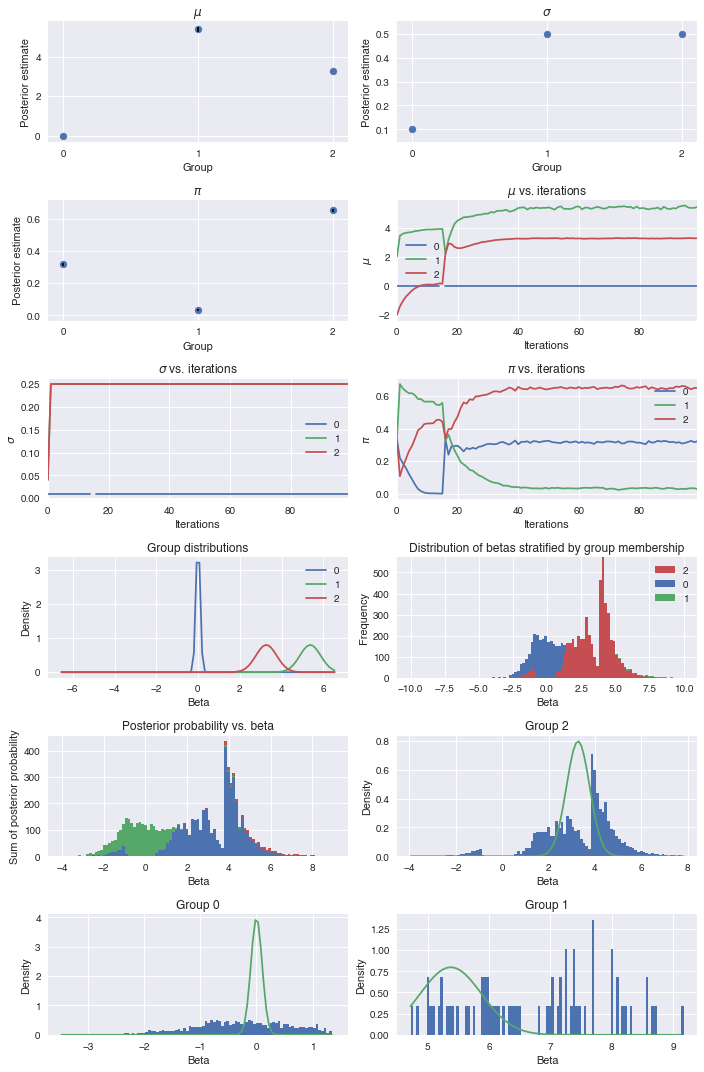

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.324810,0.5,0.000000,0.336678,0.5,0.000000,0.346917,0.5
1,3.839457,0.562249,0.5,3.855696,0.572884,0.5,3.873830,0.585520,0.5
2,-1.436196,0.084243,0.5,-1.399493,0.090438,0.5,-1.353966,0.097725,0.5


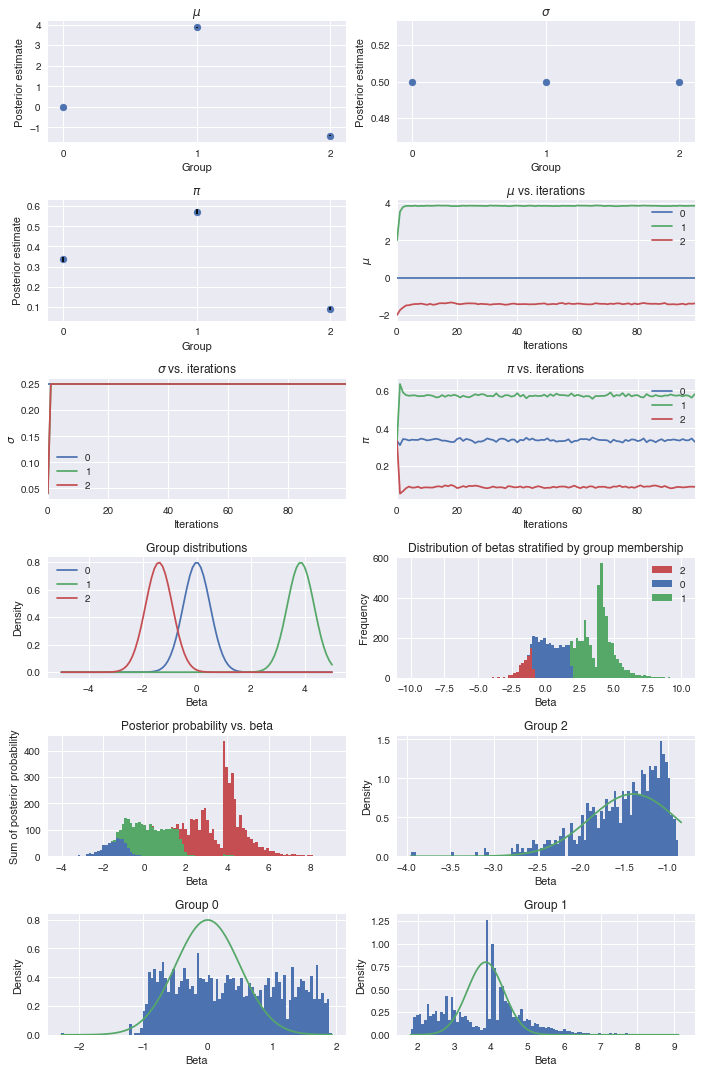

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.312210,0.10,0.000000,0.323700,0.10,0.000000,0.334063,0.10
1,3.885489,0.556636,0.05,3.891383,0.566450,0.05,3.898370,0.577947,0.05
2,-1.374810,0.104045,0.05,-1.365732,0.109849,0.05,-1.355886,0.116060,0.05


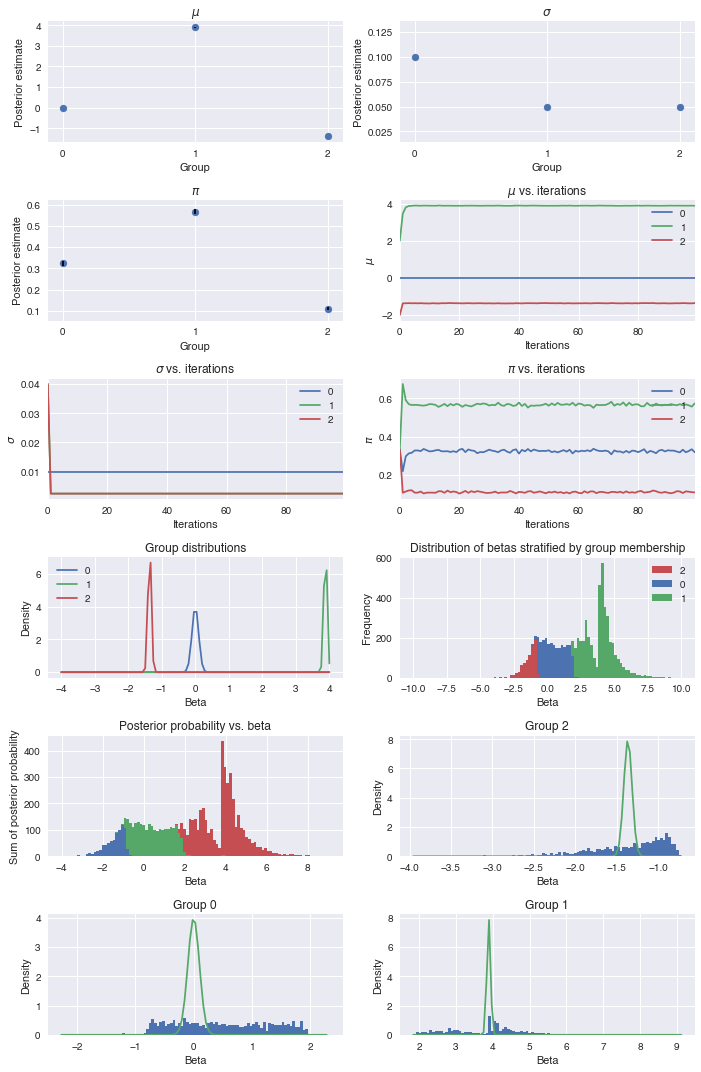

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.221674,0.10,0.000000,0.232645,0.10,0.000000,0.241249,0.10
1,3.771884,0.587810,0.25,3.782208,0.597874,0.25,3.789723,0.608017,0.25
2,-1.023142,0.161585,0.25,-1.001636,0.169481,0.25,-0.984221,0.177692,0.25


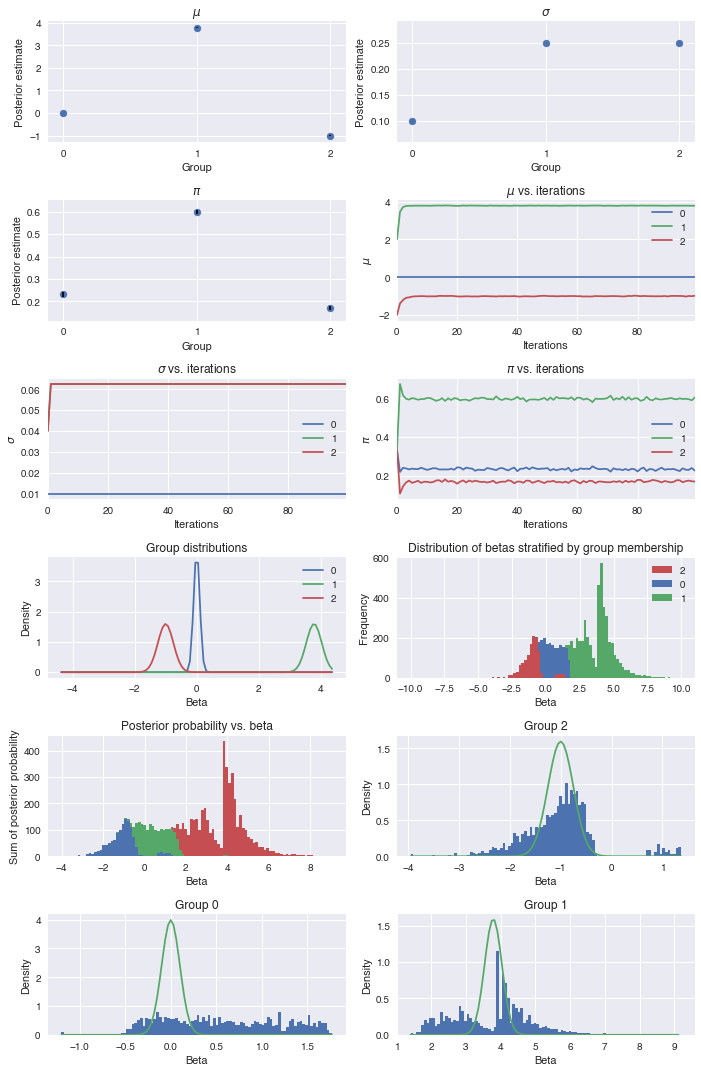

In [168]:
for p in lof_res.keys():
    visualize_piemm_res('AMR {}'.format(p), lof_res[p], lof_summary_stats['AMR'])

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.000015,0.1,0.000000,0.042312,0.1,0.000000,0.334617,0.1
1,1.009240,0.278923,0.5,3.645772,0.302527,0.5,4.137178,0.424569,0.5
2,-0.339105,0.332977,0.5,-0.069224,0.655161,0.5,0.983233,0.720932,0.5


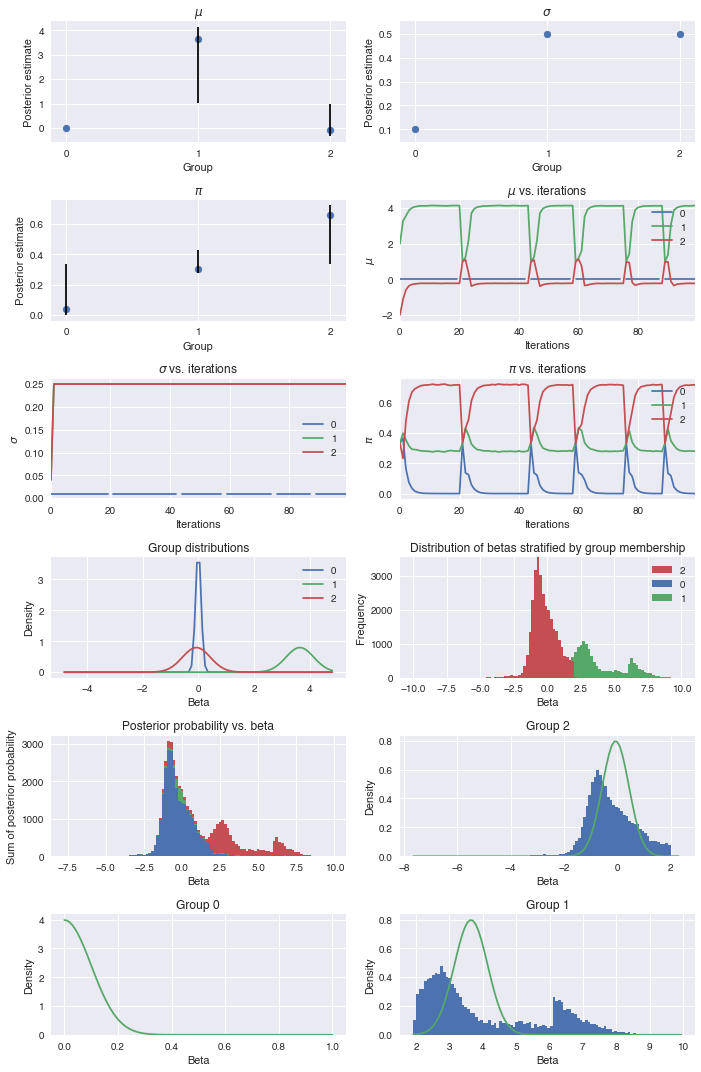

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.466032,0.5,0.000000,0.472666,0.5,0.000000,0.478929,0.5
1,4.206560,0.264568,0.5,4.215304,0.269300,0.5,4.225549,0.273612,0.5
2,-0.996377,0.253024,0.5,-0.985732,0.258035,0.5,-0.970655,0.264654,0.5


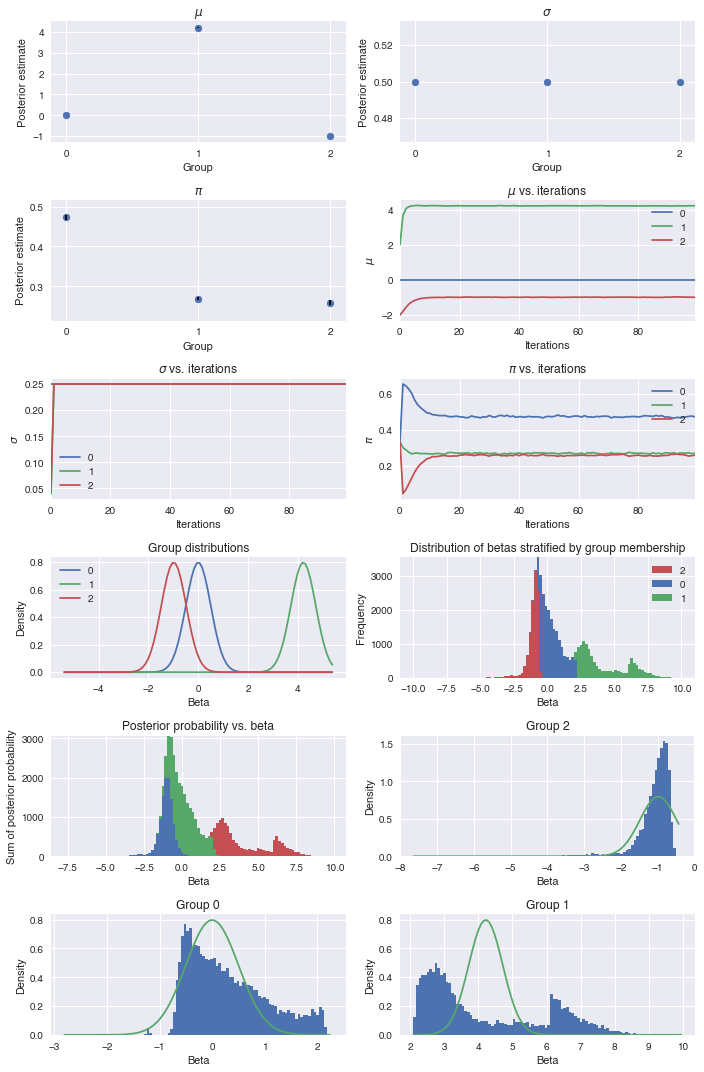

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.499264,0.10,0.000000,0.504531,0.10,0.000000,0.510138,0.10
1,4.365671,0.245635,0.05,4.368741,0.249877,0.05,4.371485,0.254646,0.05
2,-1.108172,0.241696,0.05,-1.105892,0.245592,0.05,-1.103796,0.249325,0.05


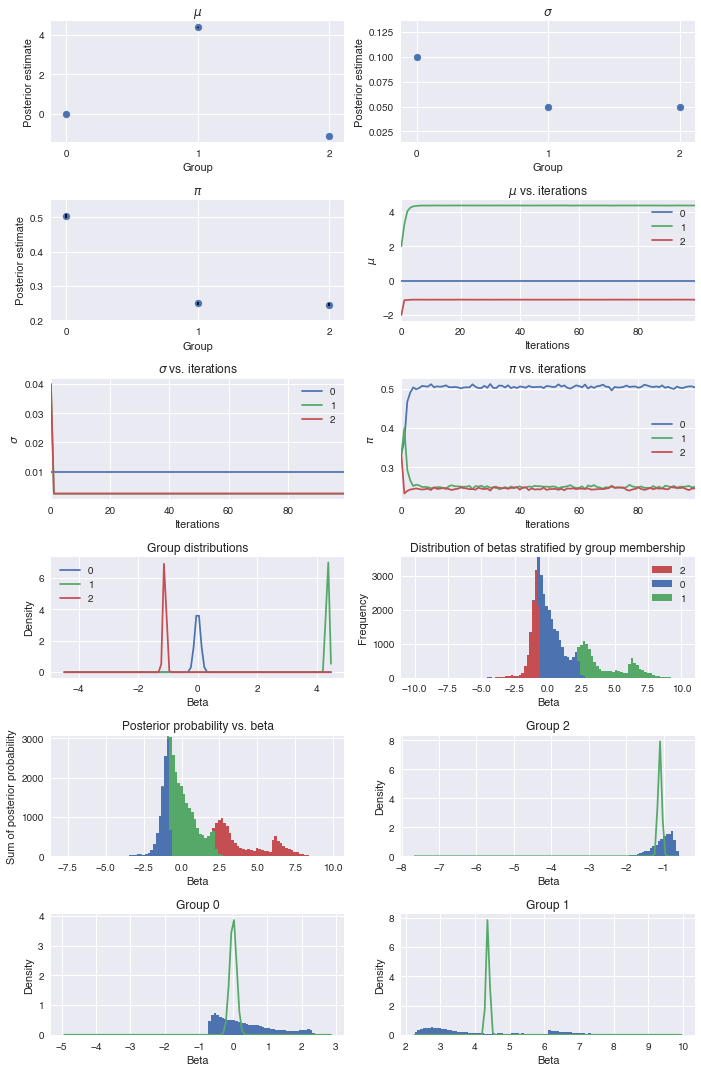

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.584844,0.10,0.000000,0.589422,0.10,0.000000,0.594111,0.10
1,6.189411,0.101251,0.25,6.199731,0.104412,0.25,6.211811,0.107974,0.25
2,2.133672,0.302243,0.25,2.143991,0.306167,0.25,2.151045,0.309973,0.25


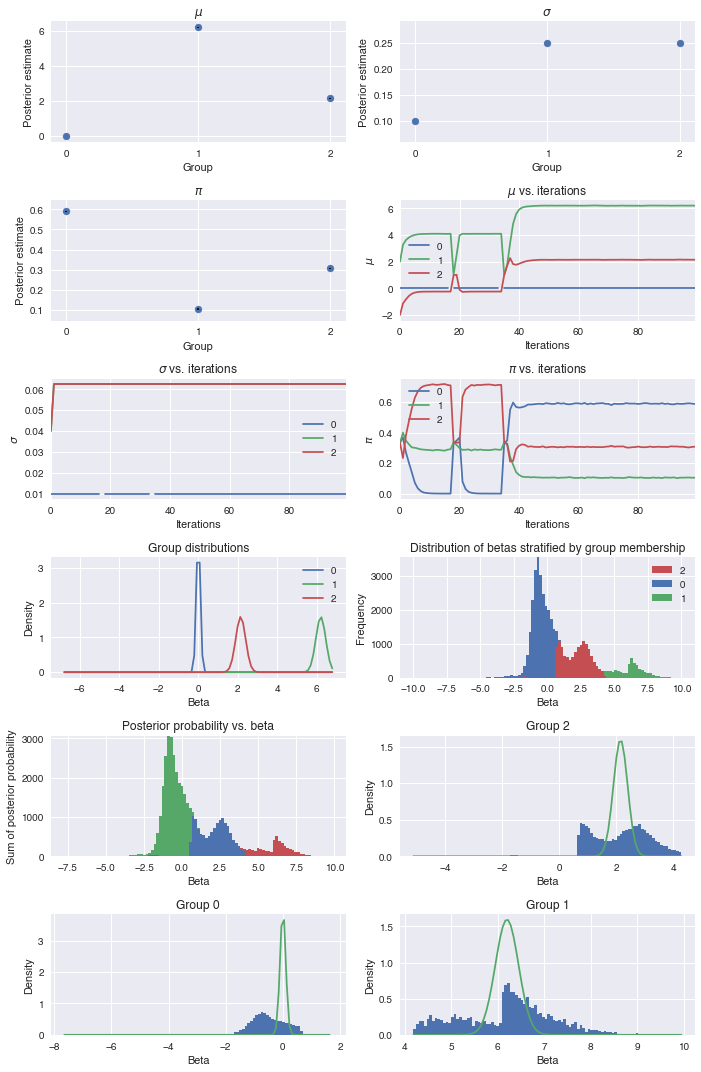

In [176]:
for p in missense_res.keys():
    visualize_piemm_res('AMR {}'.format(p), missense_res[p], missense_summary_stats['AMR'])

In [68]:
ires, ores, gamma = missense_res[missense_res.keys()[1]]
ss = missense_summary_stats['AMR'].sort_values(by='beta', ascending=False)
enriched = list(gamma[gamma[1] == 1].index)

tdf = gamma.copy(deep=True)
tdf.columns = ['group_{}'.format(x) for x in tdf.columns]
ss = ss.join(tdf)

<Container object of 99 artists>

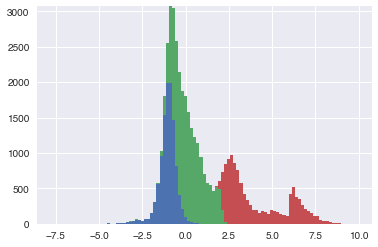

In [59]:
ss[ss.beta > 6].sort_values(by='beta').head()

,beta,se2,group
3959143,6.001704,0.183372,1
3934571,6.002367,0.036729,1
2411445,6.003199,0.288132,1
5147812,6.003297,0.672185,1
2438289,6.007908,0.096238,1


In [64]:
vrs_f.ix[ss[ss.beta > 6].sort_values(by='beta').head().index, ['AC_AMR', 'AC_NFE']]

,AC_AMR,AC_NFE
3959143,660,5
3934571,3089,27
2411445,420,3
5147812,182,1
1871040,65,0


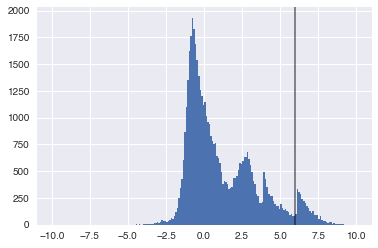

In [74]:
ss.beta.hist(bins=np.arange(-10, 10.1, 0.1))
ymin, ymax = plt.ylim()
plt.vlines(6, ymin, ymax, alpha=0.5)
plt.ylim(ymin, ymax);

In [25]:
tdf = gamma.copy(deep=True)
tdf.columns = ['group_{}'.format(x) for x in tdf.columns]
vrs_f = vrs_f.join(tdf)
vrs_f = vrs_f.join(summary_stats['AMR'])

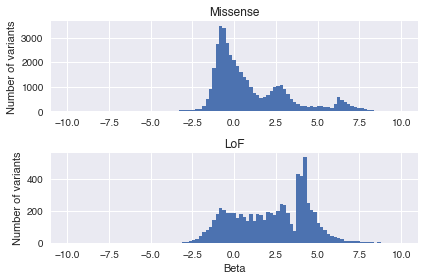

In [32]:
xmax = np.ceil(vrs_f.beta.abs().max())
xmin = -xmax

fig, axs = plt.subplots(2, 1)
vrs_f.ix[vrs_f.LoF.isnull(), 'beta'].hist(bins=np.linspace(xmin, xmax, 100), ax=axs[0]);
axs[0].set_title('Missense')
axs[0].set_ylabel('Number of variants')
vrs_f.ix[vrs_f.LoF.isnull() == False, 'beta'].hist(bins=np.linspace(xmin, xmax, 100), ax=axs[1])
axs[1].set_title('LoF')
axs[1].set_ylabel('Number of variants')
axs[1].set_xlabel('Beta')
plt.tight_layout();

In [27]:
vrs_f.ix[(vrs_f['group'] == 1) & (vrs_f['beta'] > 5), ['AC_AMR', 'AC_NFE']]

,AC_AMR,AC_NFE
1291,207,2
3306,203,0
4327,2703,50
6375,84,0
6418,147,0
8608,72,0
17810,447,0
18153,91,1
18465,1110,2
18787,84,0


In [32]:
vrs_f[vrs_f.AC_NFE >= 1].shape

(45382, 54)

In [138]:
def parse_polyphen_prediction(x):
    # The PolyPhen column can have a single value like
    # 'benign(0.311)'
    # or multiple values like
    # 'benign(0.034),benign(0.141),benign(0.01)'
    # If there are multiple values, the prediction (benign, 
    # possibly damaging, or probably damaging) can be different.
    # I'm going to take the most-damaging score and prediction.
    if type(x) is str:
        values = x.split(',')
        predictions = [x.split('(')[0] for x in values]
        scores = [float(x[:-1].split('(')[1]) for x in values]
        i = np.argmax(scores)
        return predictions[i]
    else:
        return np.nan

def parse_polyphen_score(x):
    # The PolyPhen column can have a single value like
    # 'benign(0.311)'
    # or multiple values like
    # 'benign(0.034),benign(0.141),benign(0.01)'
    # If there are multiple values, the prediction (benign, 
    # possibly damaging, or probably damaging) can be different.
    # I'm going to take the most-damaging score and prediction.
    if type(x) is str:
        values = x.split(',')
        scores = [float(x[:-1].split('(')[1]) for x in values]
        i = np.argmax(scores)
        return scores[i]
    else:
        return np.nan
    
def parse_sift_prediction(x):
    # The SIFT column can have a single value like
    # 'tolerated(0.1)'
    # or multiple values like
    # 'deleterious_low_confidence(0.02),deleterious_low_confidence(0.01)'
    # If there are multiple values, the prediction (benign, 
    # possibly damaging, or probably damaging) can be different.
    # I'm going to take the most-damaging score and prediction.
    if type(x) is str:
        values = x.split(',')
        predictions = [x.split('(')[0] for x in values]
        scores = [float(x[:-1].split('(')[1]) for x in values]
        i = np.argmin(scores)
        return predictions[i]
    else:
        return np.nan

def parse_sift_score(x):
    # The SIFT column can have a single value like
    # 'tolerated(0.1)'
    # or multiple values like
    # 'deleterious_low_confidence(0.02),deleterious_low_confidence(0.01)'
    # If there are multiple values, the prediction (benign, 
    # possibly damaging, or probably damaging) can be different.
    # I'm going to take the most-damaging score and prediction.
    if type(x) is str:
        values = x.split(',')
        scores = [float(x[:-1].split('(')[1]) for x in values]
        i = np.argmin(scores)
        return scores[i]
    else:
        return np.nan

In [131]:
vrs_f['PolyPhen_prediction'] = vrs_f.PolyPhen.apply(lambda x: parse_polyphen_prediction(x)).values
vrs_f['PolyPhen_score'] = vrs_f.PolyPhen.apply(lambda x: parse_polyphen_score(x)).values

vrs_f['SIFT_prediction'] = vrs_f.SIFT.apply(lambda x: parse_sift_prediction(x)).values
vrs_f['SIFT_score'] = vrs_f.SIFT.apply(lambda x: parse_sift_score(x)).values
vrs_f['SNP'] = (vrs_f.REF.apply(lambda x: len(x)) == 1) & (vrs_f.ALT.apply(lambda x: len(x)) == 1)

In [143]:
vrs_f.columns

Index([u'CHROM', u'POS', u'REF', u'ALT', u'AC_AFR', u'AC_AMR', u'AC_ASJ',
       u'AC_EAS', u'AC_FIN', u'AC_NFE', u'AC_OTH', u'AC_SAS', u'AN_AFR',
       u'AN_AMR', u'AN_ASJ', u'AN_EAS', u'AN_FIN', u'AN_NFE', u'AN_OTH',
       u'AN_SAS', u'Allele', u'Consequence', u'IMPACT', u'Gene', u'BIOTYPE',
       u'SIFT', u'PolyPhen', u'CLIN_SIG', u'LoF', u'LoF_filter', u'LoF_flags',
       u'LoF_info', u'AF_AFR', u'AF_AMR', u'AF_ASJ', u'AF_EAS', u'AF_FIN',
       u'AF_NFE', u'AF_OTH', u'AF_SAS', u'GP_AFR', u'GP_AMR', u'GP_ASJ',
       u'GP_EAS', u'GP_FIN', u'GP_NFE', u'GP_OTH', u'GP_SAS', u'group_0',
       u'group_1', u'group_2', u'beta', u'se2', u'group',
       u'PolyPhen_prediction', u'PolyPhen_score', u'SIFT_prediction',
       u'SIFT_score'],
      dtype='object')

I'll write a file with the variants ordered according to interest.

In [202]:
tdf = vrs_f.ix[enriched].sort_values(by=['LoF', 'PolyPhen_score', 'SIFT_score'], ascending=[True, False, True])
cols = ['CHROM', 'POS', 'REF', 'ALT', 'SNP', 'AF_AMR', 'AF_NFE', 'beta', 'se2', 'LoF', 'PolyPhen_score', 
        'SIFT_score', 'CLIN_SIG', 'AC_AMR', 'AN_AMR', 'AC_NFE', 'AN_NFE']
tdf[cols].head()

,CHROM,POS,REF,ALT,SNP,AF_AMR,AF_NFE,beta,se2,LoF,PolyPhen_score,SIFT_score,CLIN_SIG,AC_AMR,AN_AMR,AC_NFE,AN_NFE
6775,1,1226700,C,CT,False,0.000260,0.000000,3.969895,2.117690,HC,NaN,NaN,NaN,8,30804,0,95974
11129,1,1416299,A,AGGAAGCC,False,0.000638,0.000054,2.408828,0.202668,HC,NaN,NaN,NaN,20,31336,6,110432
11215,1,1417961,C,CT,False,0.000298,0.000000,4.245125,2.095277,HC,NaN,NaN,NaN,10,33578,0,111518
18998,1,2519890,A,AAGGTG,False,0.000387,0.000018,2.888316,0.474113,HC,NaN,NaN,NaN,13,33582,2,111670
21201,1,3394994,GA,G,False,0.000392,0.000000,4.478134,2.074113,HC,NaN,NaN,NaN,13,33160,0,108122


In [203]:
tdf.to_csv(os.path.join(outdir, 'amr_alleles.tsv'), sep='\t', index=False)

In [ ]:
3 +

### var0 = $0.2^2$, var1 = var2 = $0.05^2$

### var0 = $0.3^2$, var1 = var2 = $0.05^2$

### Variance = 1

### Variance = 0.5

### Variance = 0.25

### Variance not fixed

### PCSK9 Results

In [19]:
pcsk9 = gtable[gtable.gene_name == 'PCSK9'].index[0]

In [20]:
for pop in tpops:
    print(pop, summary_stats[pop].ix[pcsk9, 'beta'])

('SAS', 0.16467218072799295)
('ASJ', 0.88355492654183443)
('EAS', -0.61474677868015659)
('AMR', 0.78223606425833381)
('FIN', -3.062772917164069)
('AFR', 1.9544257207490261)


In [21]:
t = {}
for pop in tpops:
    t[pop] = piemm_res_01_05_05[pop][2].ix[pcsk9]
t = pd.DataFrame(t)
t.index = ['similar', 'enriched', 'depleted']
t

,AFR,AMR,ASJ,EAS,FIN,SAS
similar,0.0,0.0,0.039216,0.960784,0.156863,1.0
enriched,1.0,1.0,0.960784,0.000000,0.039216,0.0
depleted,0.0,0.0,0.000000,0.039216,0.803922,0.0


## Compare AFR vs. AMR

I want to compare the genes enriched for LoF variants
among African ancestry and Latino ancestry individuals.
We'll use some gene lists to focus in on interesting genes.

In [22]:
afr_gamma = piemm_res_01_05_05['AFR'][2]
amr_gamma = piemm_res_01_05_05['AMR'][2]
afr_enriched = set(afr_gamma.idxmax(axis=1)[afr_gamma.idxmax(axis=1) == 1].index)
amr_enriched = set(amr_gamma.idxmax(axis=1)[amr_gamma.idxmax(axis=1) == 1].index)

In [23]:
print('{:,} enriched genes for AFR.'.format(len(afr_enriched)))
print('{:,} enriched genes for AMR.'.format(len(amr_enriched)))
print('{:,} shared enriched genes for AFR and AMR.'.format(len(afr_enriched & amr_enriched)))

3,950 enriched genes for AFR.
3,553 enriched genes for AMR.
1,480 shared enriched genes for AFR and AMR.


### FDA approved drug targets

In [24]:
fn = ('/home/cdeboeve/cdeboeve_projects/repos/macarthur-lab/gene_lists/lists/fda_approved_drug_targets.tsv')
fda_drug_targets = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in fda_drug_targets.index:
    ind.append(gtable[gtable.gene_name == fda_drug_targets[i]].index[0])
fda_drug_targets.index = ind

print('{:,} FDA drug targets enriched for AFR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) & set(fda_drug_targets))))
print('{:,} FDA drug targets enriched for AMR.'.format(len(set(gtable.ix[amr_enriched, 'gene_name']) & set(fda_drug_targets))))
print('{:,} shared enriched FDA drug targets for AFR and AMR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) &
                                                                          set(gtable.ix[amr_enriched, 'gene_name']) &
                                                                          set(fda_drug_targets))))

fda_set = (afr_enriched | amr_enriched) & set(fda_drug_targets.index)
fda = pd.DataFrame(index=fda_set, columns=['symbol', 'AFR_beta', 'AMR_beta'])
fda['symbol'] = gtable.ix[fda.index, 'gene_name']
fda.ix[afr_enriched & set(fda.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(fda.index), 'beta']
fda.ix[amr_enriched & set(fda.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(fda.index), 'beta']
fda = fda.sort_values(by='symbol')
fda['AF_AFR'] = lof_gene.AF_AFR.ix[fda.index]
fda['AF_AMR'] = lof_gene.AF_AMR.ix[fda.index]
fda['AF_NFE'] = lof_gene.AF_NFE.ix[fda.index]
fda['AC_AFR'] = lof_gene.AC_AFR.ix[fda.index]
fda['AC_AMR'] = lof_gene.AC_AMR.ix[fda.index]
fda['AC_NFE'] = lof_gene.AC_NFE.ix[fda.index]

53 FDA drug targets enriched for AFR.
53 FDA drug targets enriched for AMR.
16 shared enriched FDA drug targets for AFR and AMR.


### Nelson et al. drug targets

In [25]:
fn = ('/home/cdeboeve/cdeboeve_projects/repos/macarthur-lab/gene_lists/lists/drug_targets_nelson.tsv')
nelson_drug_targets = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in nelson_drug_targets.index:
    if len(gtable[gtable.gene_name == nelson_drug_targets[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == nelson_drug_targets[i]].index[0])
    else:
        ind.append('NaN')
nelson_drug_targets.index = ind
nelson_drug_targets = nelson_drug_targets.drop('NaN')

print('{:,} Nelson drug targets enriched for AFR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) & set(nelson_drug_targets))))
print('{:,} Nelson drug targets enriched for AMR.'.format(len(set(gtable.ix[amr_enriched, 'gene_name']) & set(nelson_drug_targets))))
print('{:,} shared enriched Nelson drug targets for AFR and AMR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) &
                                                                          set(gtable.ix[amr_enriched, 'gene_name']) &
                                                                          set(nelson_drug_targets))))

nelson_set = (afr_enriched | amr_enriched) & set(nelson_drug_targets.index)
nelson = pd.DataFrame(index=nelson_set, columns=['symbol', 'AFR_beta', 'AMR_beta'])
nelson['symbol'] = gtable.ix[nelson.index, 'gene_name']
nelson.ix[afr_enriched & set(nelson.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(nelson.index), 'beta']
nelson.ix[amr_enriched & set(nelson.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(nelson.index), 'beta']
nelson = nelson.sort_values(by='symbol')
nelson['AF_AFR'] = lof_gene.AF_AFR.ix[nelson.index]
nelson['AF_AMR'] = lof_gene.AF_AMR.ix[nelson.index]
nelson['AF_NFE'] = lof_gene.AF_NFE.ix[nelson.index]
nelson['AC_AFR'] = lof_gene.AC_AFR.ix[nelson.index]
nelson['AC_AMR'] = lof_gene.AC_AMR.ix[nelson.index]
nelson['AC_NFE'] = lof_gene.AC_NFE.ix[nelson.index]

37 Nelson drug targets enriched for AFR.
40 Nelson drug targets enriched for AMR.
15 shared enriched Nelson drug targets for AFR and AMR.


### Rivas IBD genes

In [26]:
fn = ('../data/ibd_gwas.locset')
ibd_genes = pd.read_table(fn, header=None, squeeze=True).drop(1, axis=1)[0].drop_duplicates()
ind = []
for i in ibd_genes.index:
    if len(gtable[gtable.gene_name == ibd_genes[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == ibd_genes[i]].index[0])
    else:
        ind.append('NaN')
ibd_genes.index = ind
ibd_genes = ibd_genes.drop('NaN')

print('{:,} IBD genes enriched for AFR.'.format(len(afr_enriched & set(ibd_genes.index))))
print('{:,} IBD genes enriched for AMR.'.format(len(amr_enriched & set(ibd_genes.index))))
print('{:,} shared enriched IBD genes for AFR and AMR.'.format(len(afr_enriched & 
                                                                   amr_enriched & 
                                                                   set(ibd_genes.index))))

ibd = pd.DataFrame(index=(afr_enriched | amr_enriched) & set(ibd_genes.index), 
                   columns=['symbol', 'AFR_beta', 'AMR_beta'])
ibd['symbol'] = gtable.ix[ibd.index, 'gene_name']
ibd.ix[afr_enriched & set(ibd.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(ibd.index), 'beta']
ibd.ix[amr_enriched & set(ibd.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(ibd.index), 'beta']
ibd = ibd.sort_values(by='symbol')
ibd['AF_AFR'] = lof_gene.AF_AFR.ix[ibd.index]
ibd['AF_AMR'] = lof_gene.AF_AMR.ix[ibd.index]
ibd['AF_NFE'] = lof_gene.AF_NFE.ix[ibd.index]
ibd['AC_AFR'] = lof_gene.AC_AFR.ix[ibd.index]
ibd['AC_AMR'] = lof_gene.AC_AMR.ix[ibd.index]
ibd['AC_NFE'] = lof_gene.AC_NFE.ix[ibd.index]

59 IBD genes enriched for AFR.
41 IBD genes enriched for AMR.
16 shared enriched IBD genes for AFR and AMR.


### Autosomal recessive genes

In [27]:
fn = ('/home/cdeboeve/cdeboeve_projects/repos/macarthur-lab/gene_lists/lists/all_ar.tsv')
auto_recessive_genes = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in auto_recessive_genes.index:
    if len(gtable[gtable.gene_name == auto_recessive_genes[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == auto_recessive_genes[i]].index[0])
    else:
        ind.append('NaN')
auto_recessive_genes.index = ind
auto_recessive_genes = auto_recessive_genes.drop('NaN')

print('{:,} autosomal recessive genes enriched for AFR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) & set(auto_recessive_genes))))
print('{:,} autosomal recessive genes enriched for AMR.'.format(len(set(gtable.ix[amr_enriched, 'gene_name']) & set(auto_recessive_genes))))
print('{:,} shared enriched autosomal recessive genes for AFR and AMR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) &
                                                                          set(gtable.ix[amr_enriched, 'gene_name']) &
                                                                          set(auto_recessive_genes))))

auto_recessive = pd.DataFrame(index=(afr_enriched | amr_enriched) & set(auto_recessive_genes.index),
                              columns=['symbol', 'AFR_beta', 'AMR_beta'])
auto_recessive['symbol'] = gtable.ix[auto_recessive.index, 'gene_name']
auto_recessive.ix[afr_enriched & set(auto_recessive.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(auto_recessive.index), 'beta']
auto_recessive.ix[amr_enriched & set(auto_recessive.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(auto_recessive.index), 'beta']
auto_recessive = auto_recessive.sort_values(by='symbol')
auto_recessive['AF_AFR'] = lof_gene.AF_AFR.ix[auto_recessive.index]
auto_recessive['AF_AMR'] = lof_gene.AF_AMR.ix[auto_recessive.index]
auto_recessive['AF_NFE'] = lof_gene.AF_NFE.ix[auto_recessive.index]
auto_recessive['AC_AFR'] = lof_gene.AC_AFR.ix[auto_recessive.index]
auto_recessive['AC_AMR'] = lof_gene.AC_AMR.ix[auto_recessive.index]
auto_recessive['AC_NFE'] = lof_gene.AC_NFE.ix[auto_recessive.index]

203 autosomal recessive genes enriched for AFR.
193 autosomal recessive genes enriched for AMR.
58 shared enriched autosomal recessive genes for AFR and AMR.


### Rivas schizophrenia genes

In [28]:
fn = ('../data/tier1.txt')
schiz_genes = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in schiz_genes.index:
    if len(gtable[gtable.gene_name == schiz_genes[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == schiz_genes[i]].index[0])
    else:
        ind.append('NaN')
schiz_genes.index = ind
schiz_genes = schiz_genes.drop('NaN')

print('{:,} schizophrenia genes enriched for AFR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) & set(schiz_genes))))
print('{:,} schizophrenia genes enriched for AMR.'.format(len(set(gtable.ix[amr_enriched, 'gene_name']) & set(schiz_genes))))
print('{:,} shared enriched schizophrenia genes for AFR and AMR.'.format(len(set(gtable.ix[afr_enriched, 'gene_name']) &
                                                                          set(gtable.ix[amr_enriched, 'gene_name']) &
                                                                          set(schiz_genes))))

schiz = pd.DataFrame(index=(afr_enriched | amr_enriched) & set(schiz_genes.index),
                              columns=['symbol', 'AFR_beta', 'AMR_beta'])
schiz['symbol'] = gtable.ix[schiz.index, 'gene_name']
schiz.ix[afr_enriched & set(schiz.index), 'AFR_beta'] = summary_stats['AFR'].ix[afr_enriched & set(schiz.index), 'beta']
schiz.ix[amr_enriched & set(schiz.index), 'AMR_beta'] = summary_stats['AMR'].ix[amr_enriched & set(schiz.index), 'beta']
schiz = schiz.sort_values(by='symbol')
schiz['AF_AFR'] = lof_gene.AF_AFR.ix[schiz.index]
schiz['AF_AMR'] = lof_gene.AF_AMR.ix[schiz.index]
schiz['AF_NFE'] = lof_gene.AF_NFE.ix[schiz.index]
schiz['AC_AFR'] = lof_gene.AC_AFR.ix[schiz.index]
schiz['AC_AMR'] = lof_gene.AC_AMR.ix[schiz.index]
schiz['AC_NFE'] = lof_gene.AC_NFE.ix[schiz.index]

15 schizophrenia genes enriched for AFR.
10 schizophrenia genes enriched for AMR.
5 shared enriched schizophrenia genes for AFR and AMR.


I'll make an Excel sheet with these results.

In [29]:
writer = pd.ExcelWriter(os.path.join(outdir, 'afr_amr_enriched.xlsx'))
fda.to_excel(writer, 'fda_drug_targets')
nelson.to_excel(writer, 'nelson_drug_targets')
ibd.to_excel(writer, 'ibd_genes')
auto_recessive.to_excel(writer, 'autosomal_recessive')
schiz.to_excel(writer, 'schizophrenia_genes')
writer.save()

## Power to detect associations for GWAS genes

In [30]:
gwas = pd.read_table(('/home/cdeboeve/rivas/data/gwas_catalog_20160315/'
                      'gwas_catalog_v1.0.1-associations_e87_r2017-03-13.tsv'), low_memory=False)

I'm going to use the gene-disease associations from [this](https://thinklab.com/discussion/extracting-disease-gene-associations-from-the-gwas-catalog/80). Note that I'm using the file from [this commit](https://github.com/dhimmel/gwas-catalog/commit/a5aa4910708a3995501ebe4136d8b9d601463fa1) which is ahead of master. It includes more diseases.

In [31]:
path = ('https://raw.githubusercontent.com/dhimmel/gwas-catalog/'
        'a5aa4910708a3995501ebe4136d8b9d601463fa1/data/gene-associations.tsv')
gwas_genes = pd.read_table(path)

gwas_genes_f = gwas_genes[gwas_genes.high_confidence == 1]

vc = gtable.gene_name.value_counts()
vc = vc[vc > 1]
tdf = gtable[gtable.gene_name.apply(lambda x: x not in vc.index)]
gn_to_gid = pd.Series(tdf.index, index=tdf.gene_name.values)

gwas_genes_f.loc[:, 'gene_id'] = gn_to_gid[gwas_genes_f.symbol].values
gwas_genes_f = gwas_genes_f.dropna()

/home/cdeboeve/cdeboeve_projects/software/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/cdeboeve/cdeboeve_projects/software/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
%%R

source("/home/cdeboeve/cdeboeve_projects/projects/powersim/GeneticsDesign/R/GPC.R")

In [33]:
# Bring GPC function into python.
gpc_default_fnc = robjects.r['GPC.default']

def gpc_default(pA, RRAa, pD, nCase, ratio, pB=None, Dprime=1, alpha=5e-8, unselected=False,
                protective=False):
    """
    Wrapper around the GPC.default function that accounts for some of the bugs in the function.
    ratio is nCase / nControl
    if pB is None, it will be set to equal pA
    I'm assuming additive traits.
    """
    if pB is None:
        pB = pA
    nControl = nCase / ratio

    if protective:
        # I use the case number here but invert the ratio.
        res = gpc_default_fnc(pA=pA, pD=pD, RRAa=RRAa, RRAA=RRAa * 2, Dprime=Dprime, pB=pB, 
                              nCase=nCase, ratio=1 / float(ratio), alpha=alpha, 
                              unselected=unselected, quiet=True)
    else:
        # Due to how the control/case counts and ratio are implemented in GPC.default,
        # I have to provide nControl instead of nCase.
        res = gpc_default_fnc(pA=pA, pD=pD, RRAa=RRAa, RRAA=RRAa * 2, Dprime=Dprime, pB=pB, 
                              nCase=nControl, ratio=ratio, alpha=alpha, unselected=unselected, 
                              quiet=True)
    # Return the power estimate.
    return res[0][0]

In [34]:
def calc_power(p, rr=2):
    if p == 0:
        return 0
    else:
        return gpc_default(p, rr, 0.1, 25000, 0.5, alpha=2e-6, unselected=True)

In [35]:
ppops = list(set(pops) - set(['OTH']))

In [36]:
gwas_genes_power = pd.crosstab(gwas_genes_f.gene_id, gwas_genes_f.doid_name)
# I'm going to add in PCSK9 for CAD.
gwas_genes_power.ix[gn_to_gid['PCSK9'], 'coronary artery disease'] = 1
gwas_genes_power = gwas_genes_power.join(lof_gene.ix[gwas_genes_power.index, 
                                                     ['AF_{}'.format(x) for x in ppops]])
gwas_genes_power = gwas_genes_power.dropna()

t = gwas_genes_power[['AF_{}'.format(x) for x in ppops]].applymap(lambda x: calc_power(x))
t.columns = ['{}_rr2'.format(x.split('_')[1]) for x in t.columns]
gwas_genes_power = gwas_genes_power.join(t)

t = gwas_genes_power[['AF_{}'.format(x) for x in ppops]].applymap(lambda x: calc_power(x, 4))
t.columns = ['{}_rr4'.format(x.split('_')[1]) for x in t.columns]
gwas_genes_power = gwas_genes_power.join(t)

gwas_genes_power.index = gtable.ix[gwas_genes_power.index, 'gene_name']
gwas_genes_power.to_csv(os.path.join(outdir, 'gwas_genes_power.tsv'), sep='\t')

In [37]:
gsp_diseases = ['coronary artery disease', 'inflammatory bowel disease', 'type 1 diabetes mellitus',
                'asthma', 'epilepsy syndrome', 'autistic disorder']

power_cols0 = ['{}_rr2'.format(x) for x in ppops]
power_cols1 = ['{}_rr4'.format(x) for x in ppops]
power_cols = power_cols0 + power_cols1

cols = (['num_genes'] + 
        ['{}_50'.format(x) for x in power_cols] + 
        ['{}_80'.format(x) for x in power_cols] + 
        ['{}_50_percent'.format(x) for x in power_cols] + 
        ['{}_80_percent'.format(x) for x in power_cols])
out = pd.DataFrame(index=gsp_diseases, columns=cols)

writer = pd.ExcelWriter(os.path.join(outdir, 'gsp_diseases.xlsx'))
for c in gsp_diseases:
    
    t = gwas_genes_power.ix[gwas_genes_power[c] == 1, power_cols0]
    out.ix[c, 'num_genes'] = t.shape[0]
    se = (t > 0.5).sum()
    out.ix[c, ['{}_50'.format(x) for x in se.index]] = se.values    
    out.ix[c, ['{}_50_percent'.format(x) for x in se.index]] = (se.values / float(t.shape[0])).round(3)
    se = (t > 0.8).sum()
    out.ix[c, ['{}_80'.format(x) for x in se.index]] = se.values
    out.ix[c, ['{}_80_percent'.format(x) for x in se.index]] = (se.values / float(t.shape[0])).round(3)
    
    t = gwas_genes_power.ix[gwas_genes_power[c] == 1, power_cols1]
    se = (t > 0.5).sum()
    out.ix[c, ['{}_50'.format(x) for x in se.index]] = se.values    
    out.ix[c, ['{}_50_percent'.format(x) for x in se.index]] = (se.values / float(t.shape[0])).round(3)
    se = (t > 0.8).sum()
    out.ix[c, ['{}_80'.format(x) for x in se.index]] = se.values
    out.ix[c, ['{}_80_percent'.format(x) for x in se.index]] = (se.values / float(t.shape[0])).round(3)
    
    t = gwas_genes_power.ix[gwas_genes_power[c] == 1, 
                            power_cols].sort_index()
    t.to_excel(writer, c)
out.T.to_csv(os.path.join(outdir, 'gsp_num_powered.tsv'), sep='\t')
gsp_power = out.T.copy(deep=True)
writer.save()

## Further analysis

In [38]:
fda[fda.symbol == 'MGAM']

,symbol,AFR_beta,AMR_beta,AF_AFR,AF_AMR,AF_NFE,AC_AFR,AC_AMR,AC_NFE
ENSG00000257335,MGAM,NaN,0.940353,0.003585,0.006795,0.002666,54,223,289


In [39]:
nelson[nelson.symbol == 'APP']

,symbol,AFR_beta,AMR_beta,AF_AFR,AF_AMR,AF_NFE,AC_AFR,AC_AMR,AC_NFE
ENSG00000142192,APP,NaN,0.690371,0.000196,0.000298,0.000152,3,10,17


In [40]:
def visualize_piemm_res(pop, piemm_res, summary_stats):
    display(HTML('<h4>Results for {}</h4>'.format(pop)))
    ires, ores, gamma = piemm_res[pop]
    sum_stats = summary_stats[pop]
    fig, axs = plt.subplots(6, 2, figsize=(10, 15))
    display(ores)

In [41]:
sns.set_palette(sns.color_palette('colorblind'))

In [42]:
summary_stats['AFR'].head()

,beta,se2,group
Gene,,,
ENSG00000000419,-1.379858,2.069040,0
ENSG00000000457,0.505685,0.189008,0
ENSG00000000460,-0.099481,0.132320,0
ENSG00000000938,0.686811,0.848559,0
ENSG00000000971,-0.213458,0.740815,0


In [43]:
(summary_stats[pop]['group'] == 1).value_counts()

False    13207
True      3950
Name: group, dtype: int64

In [44]:
for pop in tpops:
    summary_stats[pop]['enriched'] = summary_stats[pop]['group'] == 1

In [45]:
sns.set_context('talk', font_scale=1.5)

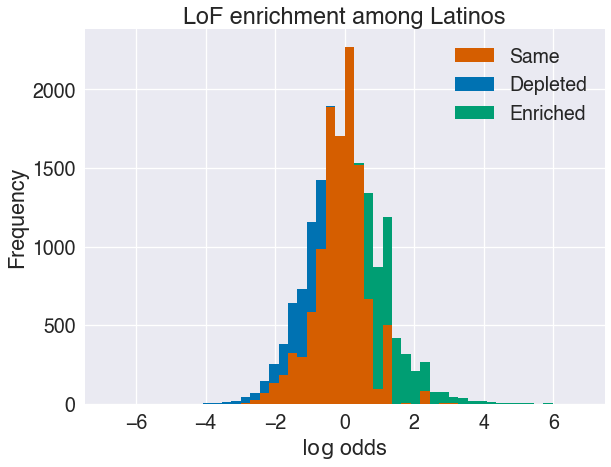

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

pop = 'AMR'
sum_stats = summary_stats[pop]
ires, ores, gamma = piemm_res_01_05_05[pop]
sum_stats['group'] = gamma.idxmax(axis=1).values
xmax = np.ceil(sum_stats.beta.abs().max())
xmax = np.round(sum_stats.beta.abs().max(), 1) + 0.1
xmin = -xmax
step = (xmax - xmin) / 50.
toplot = []
for i in [0, 2, 1]:
    toplot.append(sum_stats.ix[sum_stats.group == i, 'beta'].values)
ax.hist(toplot, stacked=True, bins=np.arange(xmin, xmax + step, step), label=['Same', 'Depleted', 'Enriched'], 
        color=[sns.color_palette()[2], sns.color_palette()[0], sns.color_palette()[1]])
ax.set_xlabel('$\log$ odds')
ax.set_ylabel('Frequency')
ax.set_title('LoF enrichment among Latinos')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'amr_lof_enr.pdf'))

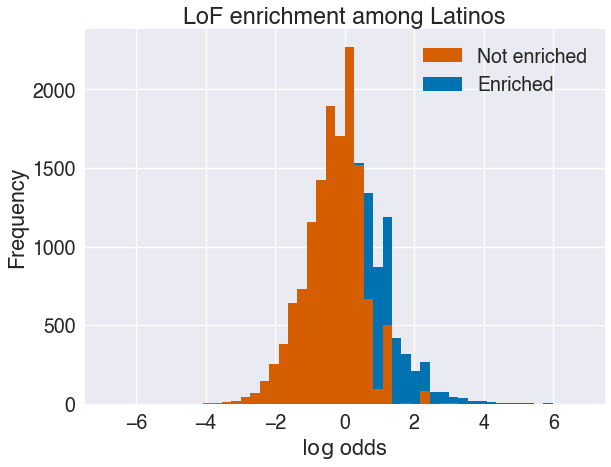

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

pop = 'AMR'
sum_stats = summary_stats[pop]
ires, ores, gamma = piemm_res_01_05_05[pop]
sum_stats['group'] = gamma.idxmax(axis=1).values
xmax = np.ceil(sum_stats.beta.abs().max())
xmax = np.round(sum_stats.beta.abs().max(), 1) + 0.1
xmin = -xmax
step = (xmax - xmin) / 50.
toplot = []
#for i in [0, 2, 1]:
#    toplot.append(sum_stats.ix[sum_stats.group == i, 'beta'].values)
toplot.append(sum_stats.ix[sum_stats.group != 1, 'beta'].values)
toplot.append(sum_stats.ix[sum_stats.group == 1, 'beta'].values)
ax.hist(toplot, stacked=True, bins=np.arange(xmin, xmax + step, step), label=['Not enriched', 'Enriched'], 
        color=[sns.color_palette()[2], sns.color_palette()[0]])
ax.set_xlabel('$\log$ odds')
ax.set_ylabel('Frequency')
ax.set_title('LoF enrichment among Latinos')
ax.legend()
plt.tight_layout()
#plt.savefig(os.path.join(outdir, 'amr_lof_enr.pdf'))

In [59]:
t = fda.ix[amr_enriched].dropna(subset=['AMR_beta'])
t = t[t.AC_AMR != 0]
t = gwas_genes_power.ix[gtable.ix[t.index, 'gene_name']].dropna()
t['diseases'] = ''
for i in t.index:
    se = t.ix[i]
    d = se[:-22]
    t.ix[i, 'diseases'] = ', '.join(d[d > 0].index)
t['odds'] = (np.e ** (fda.ix[gn_to_gid[t.index], 'AMR_beta'])).astype(float).round(1).values
t[['odds', 'diseases']].sort_values(by='odds', ascending=False).to_excel('amr_fda_gwas_odds.xls')
t[['odds', 'diseases']].sort_values(by='odds', ascending=False)

,odds,diseases
gene_name,,
IL2RB,34.1,asthma
RRM2,26.5,prostate carcinoma
PPARG,7.7,type 2 diabetes mellitus
PTGIR,6.8,ulcerative colitis
CD44,4.8,vitiligo
C5,3.6,rheumatoid arthritis
GRIA1,3.3,schizophrenia
DNMT1,3.3,narcolepsy
CTLA4,3.3,"Graves' disease, alopecia areata, celiac disea..."


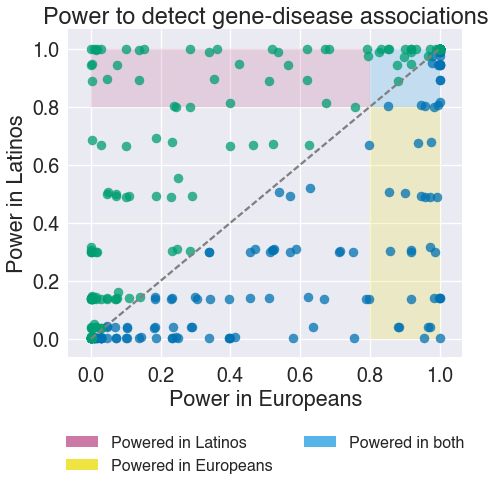

In [136]:
tdf = gwas_genes_power[gwas_genes_power[gsp_diseases].sum(axis=1) > 0]
tdf = tdf[tdf.AF_AMR > 0]
a = tdf[tdf['NFE_rr4'] > tdf['AMR_rr4']]
b = tdf[tdf['NFE_rr4'] < tdf['AMR_rr4']]

fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.95, 0.05])

ax = fig.add_subplot(gs[0, 0])
ax.set_xlabel('Power in Europeans')
ax.set_ylabel('Power in Latinos')
ax.add_patch(mpl.patches.Rectangle((0, 0.8), 0.8, 0.2, color=sns.color_palette()[3], alpha=0.25, zorder=1))
ax.add_patch(mpl.patches.Rectangle((0.8, 0), 0.2, 0.8, color=sns.color_palette()[4], alpha=0.25, zorder=1))
ax.add_patch(mpl.patches.Rectangle((0.8, 0.8), 0.2, 0.2, color=sns.color_palette()[5], alpha=0.25, zorder=1))
ax.scatter(a['NFE_rr4'], a['AMR_rr4'], alpha=0.75, zorder=2)
ax.scatter(b['NFE_rr4'], b['AMR_rr4'], alpha=0.75, zorder=2)
ax.set_title('Power to detect gene-disease associations')
ax.plot([0, 1], [0, 1], color='grey', ls='--')

ax = fig.add_subplot(gs[1, 0])
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
for sp in ax.spines.values():
    sp.set_visible(False)
ax.set_facecolor('white')
rects = [plt.Rectangle((0, 0), 0, 0, fc=sns.color_palette()[3]), 
         plt.Rectangle((0, 0), 0, 0, fc=sns.color_palette()[4]),
         plt.Rectangle((0, 0), 0, 0, fc=sns.color_palette()[5])]
lgd = ax.legend(rects, ['Powered in Latinos', 'Powered in Europeans', 'Powered in both'], 
                loc='upper center', frameon=False, prop={'size':16}, ncol=2)

gs.tight_layout(fig, rect = [0, 0.1, 1, 1])
plt.savefig(os.path.join(outdir, 'gene_disease_assoc_power.pdf'))

In [172]:
tdf = gwas_genes_power[gwas_genes_power[gsp_diseases].sum(axis=1) > 0]
tdf = tdf[tdf.AF_AMR > 0]
tdf = tdf[(tdf['AMR_rr4'] > 0.8) & (tdf['NFE_rr4'] < 0.8)]
tdf = tdf.sort_values(by='AMR_rr4', ascending=False)
tdf['diseases'] = ''
for i in tdf.index:
    se = tdf.ix[i]
    d = se[:-22]
    tdf.ix[i, 'diseases'] = ', '.join(d[d > 0].index)
tdf['diseases'] = tdf['diseases'].apply(lambda x: x.replace('type 1 diabetes mellitus', 'T1D'))
tdf['diseases'] = tdf['diseases'].apply(lambda x: x.replace('inflammatory bowel disease', 'IBD'))
tdf['diseases'] = tdf['diseases'].apply(lambda x: x.replace('epilepsy syndrome', 'epilepsy'))
tdf['diseases'] = tdf['diseases'].apply(lambda x: x.replace('autistic disorder', 'autism'))
tdf[['AMR_rr4', 'NFE_rr4', 'diseases']].round(2).to_excel('amr_nfe_power.xls')
tdf[['AMR_rr4', 'NFE_rr4', 'diseases']].head(12)

,AMR_rr4,NFE_rr4,diseases
gene_name,,,
PTGDR2,1.000000,0.000977,IBD
IL2RB,1.000000,0.007739,asthma
CCL7,1.000000,0.028092,"Crohn's disease, IBD"
RBPJ,1.000000,0.016931,"rheumatoid arthritis, T1D"
IL19,1.000000,0.100979,"Crohn's disease, IBD, ulcerative colitis"
ATXN2L,1.000000,0.360661,IBD
GSDMB,1.000000,0.791866,"Crohn's disease, asthma, IBD, primary biliary ..."
KIAA1841,0.999999,0.682694,"Crohn's disease, IBD"
TMBIM1,0.999989,0.520112,IBD


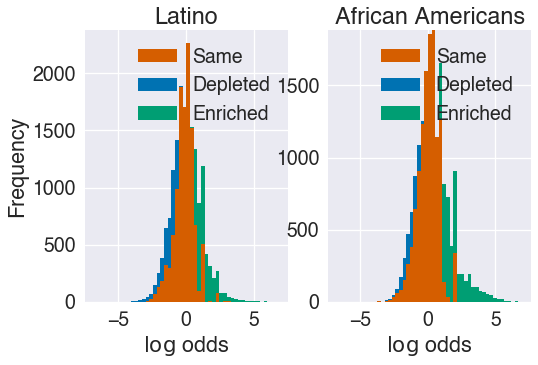

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

ax = axs[0]
pop = 'AMR'
sum_stats = summary_stats[pop]
ires, ores, gamma = piemm_res_01_05_05[pop]
sum_stats['group'] = gamma.idxmax(axis=1).values
xmax = np.ceil(sum_stats.beta.abs().max())
xmax = np.round(sum_stats.beta.abs().max(), 1) + 0.1
xmin = -xmax
step = (xmax - xmin) / 50.
toplot = []
for i in [0, 2, 1]:
    toplot.append(sum_stats.ix[sum_stats.group == i, 'beta'].values)
ax.hist(toplot, stacked=True, bins=np.arange(xmin, xmax + step, step), label=['Same', 'Depleted', 'Enriched'], 
        color=[sns.color_palette()[2], sns.color_palette()[0], sns.color_palette()[1]])
ax.set_xlabel('$\log$ odds')
ax.set_ylabel('Frequency')
ax.set_title('Latino')
ax.legend()

ax = axs[1]
pop = 'AFR'
sum_stats = summary_stats[pop]
ires, ores, gamma = piemm_res_01_05_05[pop]
sum_stats['group'] = gamma.idxmax(axis=1).values
xmax = np.ceil(sum_stats.beta.abs().max())
xmax = np.round(sum_stats.beta.abs().max(), 1) + 0.1
xmin = -xmax
step = (xmax - xmin) / 50.
toplot = []
for i in  [0, 2, 1]:
    toplot.append(sum_stats.ix[sum_stats.group == i, 'beta'].values)
ax.hist(toplot, stacked=True, bins=np.arange(xmin, xmax + step, step), label=['Same', 'Depleted', 'Enriched'], 
        color=[sns.color_palette()[2], sns.color_palette()[0], sns.color_palette()[1]])
ax.set_xlabel('$\log$ odds')
ax.set_title('African Americans')
ax.legend();

In [51]:
schiz[schiz.AF_AFR > 0.01]

,symbol,AFR_beta,AMR_beta,AF_AFR,AF_AMR,AF_NFE,AC_AFR,AC_AMR,AC_NFE
ENSG00000120885,CLU,4.8203,1.99008,0.019068,0.001133,0.000153,291,38,17
ENSG00000002822,MAD1L1,3.16246,NaN,0.016520,0.000929,0.000707,248,31,78


In [52]:
schiz.max()

symbol          TSNARE1
AFR_beta         4.8203
AMR_beta        1.99008
AF_AFR        0.0190682
AF_AMR       0.00113264
AF_NFE      0.000707278
AC_AFR              291
AC_AMR               38
AC_NFE               78
dtype: object

In [53]:
ibd[ibd.AF_AFR > 0.01]

,symbol,AFR_beta,AMR_beta,AF_AFR,AF_AMR,AF_NFE,AC_AFR,AC_AMR,AC_NFE
ENSG00000176920,FUT2,4.57189,2.52202,0.024084,0.003157,0.000251,368,106,28
ENSG00000142224,IL19,4.79229,2.33665,0.010131,0.000865,0.000081,155,29,9


In [54]:
3 + 

SyntaxError: invalid syntax (<ipython-input-54-4715fb1d5390>, line 1)

### Heterogeneity

I'd like to look and see whether LoF variants are evenly distributed across
alleles or whether they are driven by a small number of varaints for each gene.

In [ ]:
vc = lof_only_f.Gene.value_counts()

In [ ]:
pvals = []
for gene in afr_enriched:
    se = lof_only_f.ix[lof_only_f.Gene == gene, 'AC_AFR']
    pvals.append(stats.chisquare(se[se > 0])[1])

In [ ]:
pd.Series(pvals).dropna().hist()